# Simple Toy TS Training for Deep3D+

In [1]:
"""
Simple tester for the deep3d
"""
import tensorflow as tf
import Deep3D_branched as deep3d
import utils
import numpy as np
import os
import os.path
import h5py

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Importing Data from H5 Format for fast loading
- Will eventually unit test dynamic CPU data loading pipeline here

In [2]:
inria_file = '/a/data/deep3d_data/inria_data.h5'
# inria_file = 'data/inria_data.h5'
h5f = h5py.File(inria_file,'r')

X_train_0 = h5f['X_0'][:,10:170,16:304,:]
Y_train_0 = h5f['Y_0'][:,10:170,16:304,:]
X_train_1 = h5f['X_1'][:,10:170,16:304,:]
Y_train_1 = h5f['Y_1'][:,10:170,16:304,:]
X_train_2 = h5f['X_2'][:,10:170,16:304,:]
Y_train_2 = h5f['Y_2'][:,10:170,16:304,:]
X_train_3 = h5f['X_3'][:,10:170,16:304,:]
Y_train_3 = h5f['Y_3'][:,10:170,16:304,:]
X_train_4 = h5f['X_4'][:,10:170,16:304,:]
Y_train_4 = h5f['Y_4'][:,10:170,16:304,:]
X_train_5 = h5f['X_5'][:,10:170,16:304,:]
Y_train_5 = h5f['Y_5'][:,10:170,16:304,:]
X_train_6 = h5f['X_6'][:,10:170,16:304,:]
Y_train_6 = h5f['Y_6'][:,10:170,16:304,:]
#X_train_7 = h5f['X_7'][:,10:170,16:304,:]
#Y_train_7 = h5f['Y_7'][:,10:170,16:304,:]


X_val = h5f['X_7'][:,10:170,16:304,:]
Y_val = h5f['Y_7'][:,10:170,16:304,:]
  
h5f.close()



# ------------------------------------------#
X_train = np.concatenate([X_train_0,X_train_1,X_train_2,X_train_3,X_train_4,X_train_5,X_train_6])
Y_train = np.concatenate([Y_train_0,Y_train_1,Y_train_2,Y_train_3,Y_train_4,Y_train_5,Y_train_6])

print "Training Size:" + str(X_train.shape)
print "Validation Size:" + str(X_val.shape)

Training Size:(3500, 160, 288, 3)
Validation Size:(443, 160, 288, 3)


## Training Loop

In [3]:
batchsize = 64
num_epochs = 25
num_batches = (X_train.shape[0]/batchsize)*num_epochs
print_step = 1
viz_step = 10

# Define config for GPU memory debugging 
config = tf.ConfigProto()
config.gpu_options.allow_growth=True  # Switch to True for dynamic memory allocation instead of TF hogging BS
config.gpu_options.per_process_gpu_memory_fraction= 1  # Cap TF mem usage
config.allow_soft_placement=True
with tf.device('/gpu:0'):
    # Session
    sess = tf.Session(config=config)
    
    # Placeholders
    images = tf.placeholder(tf.float32, [None, 160, 288, 3], name='input_batch')
    true_out = tf.placeholder(tf.float32, [None, 160, 288, 3] , name='ground_truth')
    train_mode = tf.placeholder(tf.bool, name='train_mode')

    # Building Net based on VGG weights 
    net = deep3d.Deep3Dnet('./vgg19.npy', dropout = 0.5)
    net.build(images, train_mode)

    # Print number of variables used: 143667240 variables, i.e. ideal size = 548MB
    print 'Variable count:'
    print(net.get_var_count())
    
    # Run initializer 
    sess.run(tf.global_variables_initializer())
   
    # Define Training Objectives
    with tf.variable_scope("Loss"):
        #reg_factor = 1e-5
        cost = tf.reduce_sum(tf.abs(net.prob - true_out))/batchsize
    
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):    
        train = tf.train.GradientDescentOptimizer(0.002).minimize(cost)
        
    # Track Cost    
    tf.summary.scalar('cost', cost)
    # tensorboard operations to compile summary and then write into logs
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('./tensorboard_logs/', graph = sess.graph)

    
    # Training Loop
    print ""
    print "== Start training =="
    for i in xrange(num_batches):
        # Creating Batch
        image_mask = np.random.choice(X_train.shape[0],batchsize)
        images_in = X_train[image_mask,:,:,:]
        labels_in = Y_train[image_mask,:,:,:]

        # Traing Step
        _, cost_val, summary = sess.run([train, cost, merged], feed_dict={images: images_in, true_out: labels_in, train_mode: True})
        writer.add_summary(summary, i)

        # No longer needed: cost_hist.append(cost_val)
        if i%print_step == 0:
            print ("({}/{})".format(i, num_batches).ljust(10) + ' | Cost: ' + str(cost_val))
    
    
    print ""
    print "Training Completed, storing weights"
    # Store Traing Output
    net.save_npy(sess)
    

Variable count:
139063583

== Start training ==
(0/1350)   | Cost: 11899.1
(1/1350)   | Cost: 9675.61
(2/1350)   | Cost: 7755.21
(3/1350)   | Cost: 7386.97
(4/1350)   | Cost: 8612.39
(5/1350)   | Cost: 8151.75
(6/1350)   | Cost: 7362.8
(7/1350)   | Cost: 6829.11
(8/1350)   | Cost: 7713.1
(9/1350)   | Cost: 7498.86
(10/1350)  | Cost: 7201.28
(11/1350)  | Cost: 7373.93
(12/1350)  | Cost: 7314.89
(13/1350)  | Cost: 7069.09
(14/1350)  | Cost: 6960.51
(15/1350)  | Cost: 7472.9
(16/1350)  | Cost: 7448.32
(17/1350)  | Cost: 7227.23
(18/1350)  | Cost: 7656.41
(19/1350)  | Cost: 7613.36
(20/1350)  | Cost: 7299.02
(21/1350)  | Cost: 7388.33
(22/1350)  | Cost: 7672.46
(23/1350)  | Cost: 8234.62
(24/1350)  | Cost: 7395.34
(25/1350)  | Cost: 7839.51
(26/1350)  | Cost: 6673.65
(27/1350)  | Cost: 6605.32
(28/1350)  | Cost: 7809.98
(29/1350)  | Cost: 7079.0
(30/1350)  | Cost: 7164.27
(31/1350)  | Cost: 8052.91
(32/1350)  | Cost: 6865.21
(33/1350)  | Cost: 7204.79
(34/1350)  | Cost: 7652.38
(35/1350)  

(303/1350) | Cost: 7816.57
(304/1350) | Cost: 7289.9
(305/1350) | Cost: 7763.64
(306/1350) | Cost: 7394.21
(307/1350) | Cost: 7031.37
(308/1350) | Cost: 7328.73
(309/1350) | Cost: 7068.65
(310/1350) | Cost: 7195.31
(311/1350) | Cost: 8051.46
(312/1350) | Cost: 7151.04
(313/1350) | Cost: 7861.42
(314/1350) | Cost: 6792.2
(315/1350) | Cost: 8118.5
(316/1350) | Cost: 7250.6
(317/1350) | Cost: 7591.52
(318/1350) | Cost: 7868.83
(319/1350) | Cost: 6963.14
(320/1350) | Cost: 8026.04
(321/1350) | Cost: 7818.98
(322/1350) | Cost: 7313.2
(323/1350) | Cost: 7046.25
(324/1350) | Cost: 7561.36
(325/1350) | Cost: 7561.86
(326/1350) | Cost: 7481.9
(327/1350) | Cost: 7398.04
(328/1350) | Cost: 7481.29
(329/1350) | Cost: 7525.73
(330/1350) | Cost: 8113.27
(331/1350) | Cost: 7098.02
(332/1350) | Cost: 7253.54
(333/1350) | Cost: 7137.8
(334/1350) | Cost: 7303.69
(335/1350) | Cost: 8235.63
(336/1350) | Cost: 7342.01
(337/1350) | Cost: 6762.58
(338/1350) | Cost: 7120.56
(339/1350) | Cost: 7521.8
(340/1350

(608/1350) | Cost: 7583.11
(609/1350) | Cost: 7981.36
(610/1350) | Cost: 7413.24
(611/1350) | Cost: 6768.55
(612/1350) | Cost: 7354.28
(613/1350) | Cost: 8154.9
(614/1350) | Cost: 7169.2
(615/1350) | Cost: 6912.17
(616/1350) | Cost: 8147.36
(617/1350) | Cost: 7855.77
(618/1350) | Cost: 8287.21
(619/1350) | Cost: 8923.01
(620/1350) | Cost: 7484.27
(621/1350) | Cost: 7153.46
(622/1350) | Cost: 7577.49
(623/1350) | Cost: 7874.29
(624/1350) | Cost: 7451.41
(625/1350) | Cost: 7969.14
(626/1350) | Cost: 7488.8
(627/1350) | Cost: 7636.89
(628/1350) | Cost: 7366.01
(629/1350) | Cost: 7857.67
(630/1350) | Cost: 7424.75
(631/1350) | Cost: 7273.65
(632/1350) | Cost: 7033.99
(633/1350) | Cost: 7415.91
(634/1350) | Cost: 7659.33
(635/1350) | Cost: 7412.19
(636/1350) | Cost: 7682.45
(637/1350) | Cost: 8452.46
(638/1350) | Cost: 6832.54
(639/1350) | Cost: 7496.16
(640/1350) | Cost: 7595.71
(641/1350) | Cost: 8250.54
(642/1350) | Cost: 7498.82
(643/1350) | Cost: 7838.3
(644/1350) | Cost: 7388.78
(645/

(913/1350) | Cost: 7906.84
(914/1350) | Cost: 7859.3
(915/1350) | Cost: 7879.37
(916/1350) | Cost: 7196.15
(917/1350) | Cost: 7607.75
(918/1350) | Cost: 7391.42
(919/1350) | Cost: 7767.24
(920/1350) | Cost: 7975.0
(921/1350) | Cost: 8202.37
(922/1350) | Cost: 7864.43
(923/1350) | Cost: 7575.26
(924/1350) | Cost: 8052.58
(925/1350) | Cost: 7326.52
(926/1350) | Cost: 7161.05
(927/1350) | Cost: 7476.17
(928/1350) | Cost: 7803.13
(929/1350) | Cost: 6904.0
(930/1350) | Cost: 7660.79
(931/1350) | Cost: 7258.25
(932/1350) | Cost: 7559.11
(933/1350) | Cost: 7334.37
(934/1350) | Cost: 7427.56
(935/1350) | Cost: 8075.7
(936/1350) | Cost: 7857.26
(937/1350) | Cost: 8003.52
(938/1350) | Cost: 8433.5
(939/1350) | Cost: 7101.69
(940/1350) | Cost: 7377.1
(941/1350) | Cost: 7326.08
(942/1350) | Cost: 8036.18
(943/1350) | Cost: 8334.11
(944/1350) | Cost: 6963.42
(945/1350) | Cost: 7546.41
(946/1350) | Cost: 7576.71
(947/1350) | Cost: 7042.33
(948/1350) | Cost: 7362.13
(949/1350) | Cost: 7572.5
(950/135

(1210/1350) | Cost: 7392.29
(1211/1350) | Cost: 7617.88
(1212/1350) | Cost: 7661.33
(1213/1350) | Cost: 7131.46
(1214/1350) | Cost: 8405.71
(1215/1350) | Cost: 8224.16
(1216/1350) | Cost: 7414.04
(1217/1350) | Cost: 8088.84
(1218/1350) | Cost: 7291.1
(1219/1350) | Cost: 7283.04
(1220/1350) | Cost: 6740.55
(1221/1350) | Cost: 7546.14
(1222/1350) | Cost: 6681.3
(1223/1350) | Cost: 8430.27
(1224/1350) | Cost: 7442.66
(1225/1350) | Cost: 7492.64
(1226/1350) | Cost: 7402.32
(1227/1350) | Cost: 6863.25
(1228/1350) | Cost: 7085.95
(1229/1350) | Cost: 7475.19
(1230/1350) | Cost: 7755.11
(1231/1350) | Cost: 7644.58
(1232/1350) | Cost: 7163.88
(1233/1350) | Cost: 7264.58
(1234/1350) | Cost: 7727.67
(1235/1350) | Cost: 7599.91
(1236/1350) | Cost: 8040.93
(1237/1350) | Cost: 7341.44
(1238/1350) | Cost: 6871.31
(1239/1350) | Cost: 6980.52
(1240/1350) | Cost: 7266.98
(1241/1350) | Cost: 7520.28
(1242/1350) | Cost: 8317.43
(1243/1350) | Cost: 8091.92
(1244/1350) | Cost: 7588.52
(1245/1350) | Cost: 72

## Testing Output

In [19]:
# Test
test_img = np.expand_dims(X_val[140], axis = 0)
test_ans = Y_val[140]

with tf.device("/gpu:0"):
    res, mask, up_conv = sess.run([net.prob, net.mask, net.up_conv], 
                                  feed_dict={images: test_img, train_mode: False})

--- Input ---


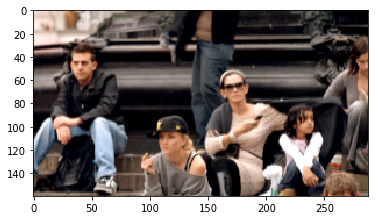

--- GT ---


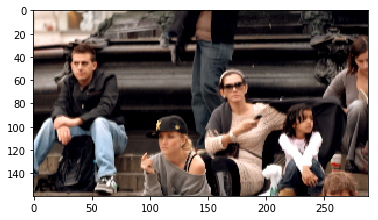

--- Our result ---


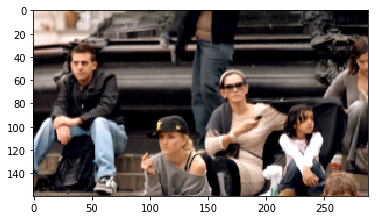

In [20]:
import matplotlib.pyplot as plt
print "--- Input ---"
plt.imshow(test_img[0])
plt.show()

print "--- GT ---"
plt.imshow(test_ans)
plt.show()

print "--- Our result ---"
plt.imshow(res[0])
plt.show()

#pyplot.imsave('1.jpeg', test_img[0])
#pyplot.imsave('2.jpeg', res[0])

## Looking at Disparity Maps

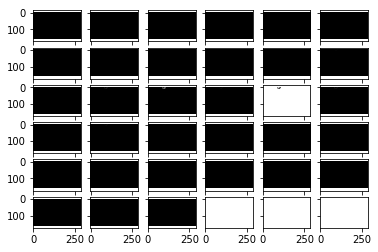

In [21]:
f, axs = plt.subplots(6, 6, sharex='col', sharey='row')

for i in range(33):
    axs[i/6][i%6].imshow(mask[0,:,:,i],cmap="gray",vmin=0.0, vmax=1.0)
plt.show()

In [22]:
max_shift_channel = np.argmax(mask,axis = 3)
max_shift_channel[0]

array([[16, 16, 16, ..., 16, 16, 14],
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16],
       ..., 
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 17, 16, 16],
       [16, 16, 16, ..., 17, 16, 16]])

In [23]:
channel_mean = np.mean(mask[0], axis =(0,1))
channel_mean

array([  1.91141407e-05,   1.91141407e-05,   1.91141407e-05,
         1.91141407e-05,   1.91141407e-05,   1.91141407e-05,
         1.91141407e-05,   1.91141407e-05,   1.91141407e-05,
         1.95048560e-05,   1.92761454e-05,   5.90097516e-05,
         6.67474887e-05,   3.06209258e-04,   2.28829612e-03,
         3.28739203e-04,   9.94083762e-01,   2.20362865e-03,
         4.76391069e-05,   1.08817585e-04,   4.54369583e-05,
         4.08281667e-05,   1.92101961e-05,   1.91141407e-05,
         1.91141407e-05,   1.91141407e-05,   1.91141407e-05,
         1.91141407e-05,   1.91141407e-05,   1.91141407e-05,
         1.91174659e-05,   1.91141407e-05,   1.91141407e-05], dtype=float32)

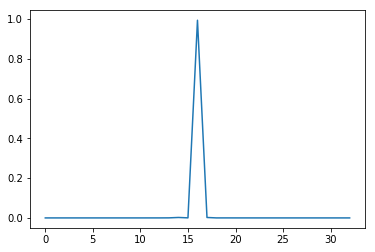

In [24]:
plt.plot(channel_mean)
plt.show()

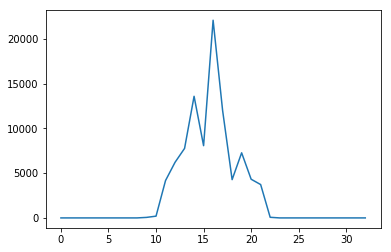

In [25]:
channel_act_mean = np.mean(up_conv[0], axis =(0,1))
plt.plot(channel_act_mean)
plt.show()

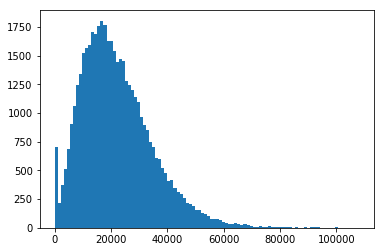

In [26]:
plt.hist(up_conv[0,:,:,16].ravel(), bins=100)
plt.show()

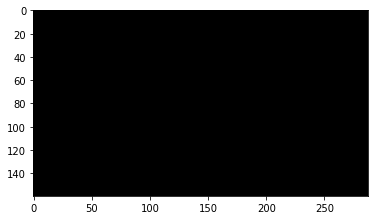

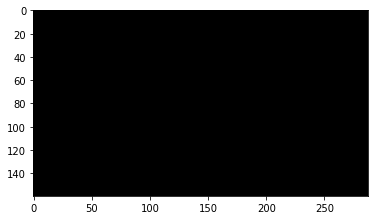

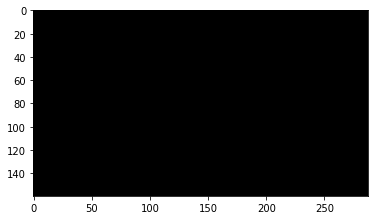

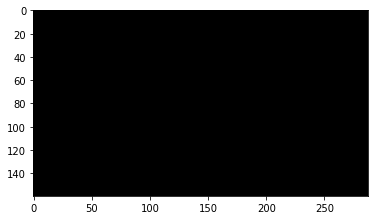

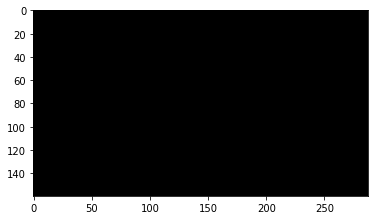

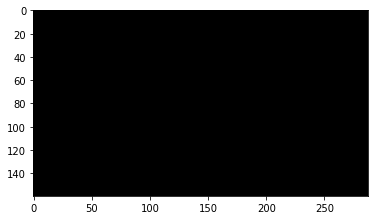

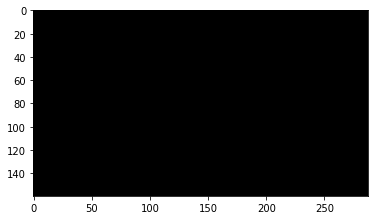

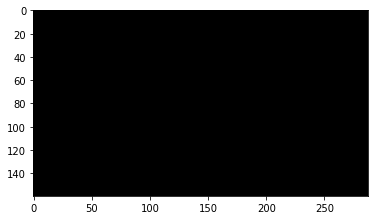

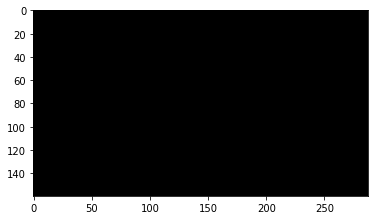

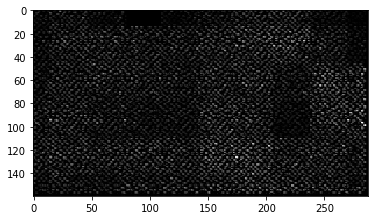

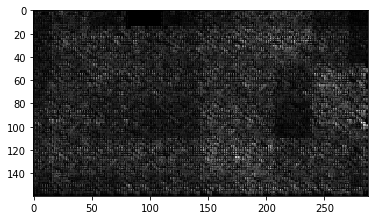

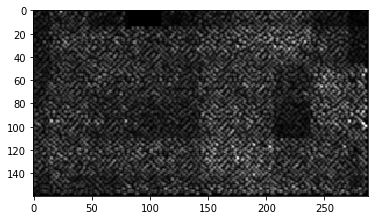

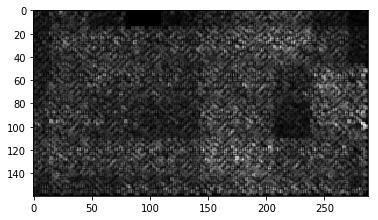

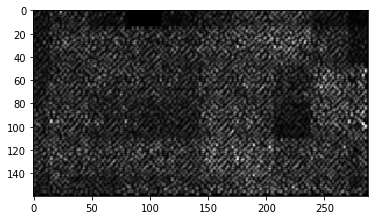

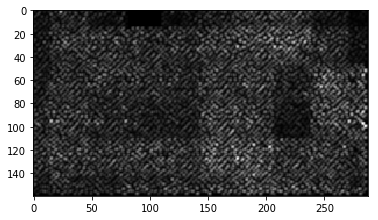

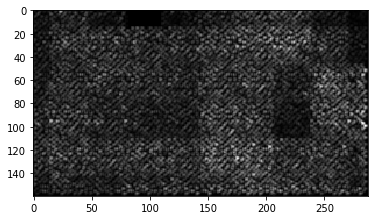

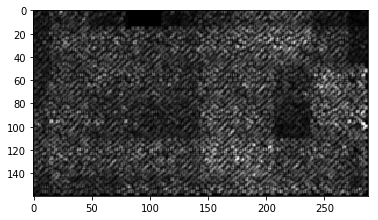

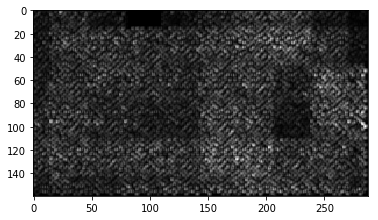

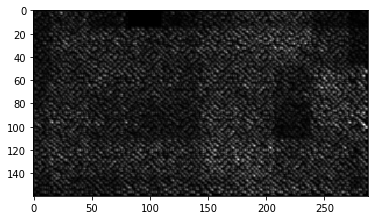

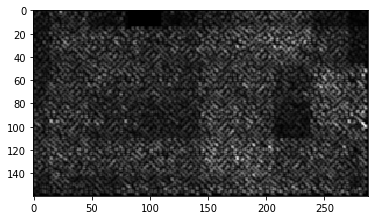

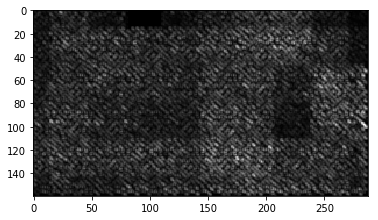

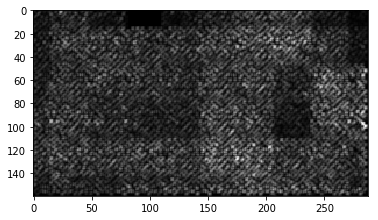

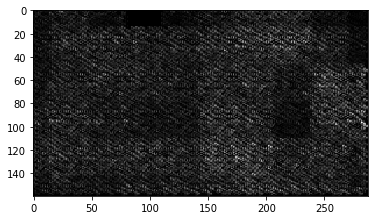

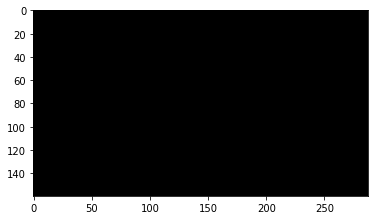

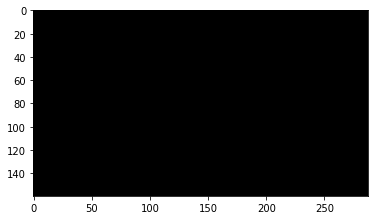

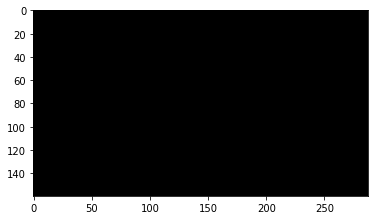

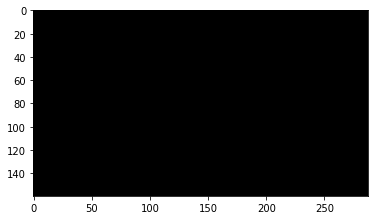

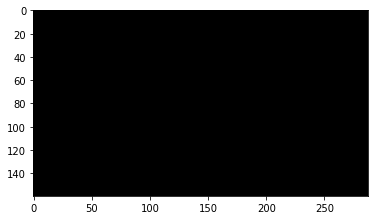

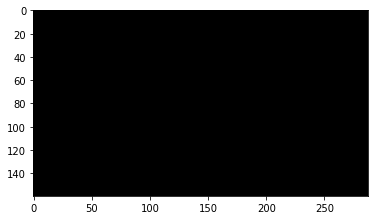

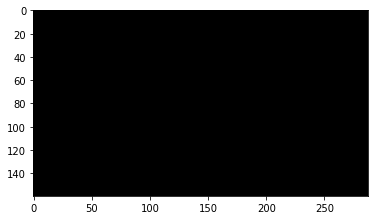

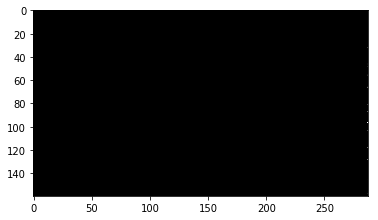

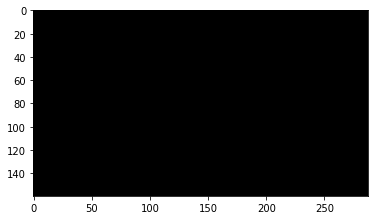

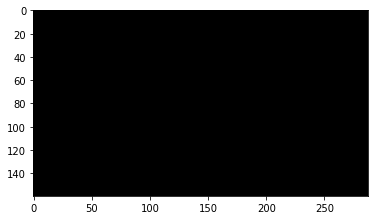

In [27]:
for layer in range(0,33):
    plt.imshow(up_conv[0,:,:,layer],cmap="gray", vmin= 0, vmax=up_conv[0,:,:,layer].max())
    plt.show()